In [1]:
#importing all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from sklearn.utils import resample 
import lightgbm as lgb
from tqdm import tqdm
import random
from datetime import date,timedelta
from datetime import datetime
from tqdm import tqdm
import pickle
tqdm.pandas()
import gc

/home/analytics/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df=pd.read_csv('IRM_31_60_days_modeling_data_left_join.csv')
cus_pmt_data=pd.read_csv('Customer_profiling_ratio.csv')

In [3]:
cus_pmt_data.shape,df.shape

((250520, 10), (333170, 48))

In [4]:
#merging customer ratio data with qelinquency data 
df=df.merge(cus_pmt_data[['Customer Number','Ratio of Invoices Paid 31-60 Days']],how='left',on='Customer Number')

In [5]:
df=df.fillna(0)

In [6]:
df['Payment Flag'].value_counts()

NOT PAID    228027
PAID        105143
Name: Payment Flag, dtype: int64

In [7]:
df.shape

(333170, 49)

In [8]:
def dollar_conversion_invoice_amount(data):
    if data['Region']=='US':
        return data['Invoice Amount']
    else:
        return data['Invoice Amount']*0.75

In [9]:
def dollar_conversion_total_past_due(data):
    if data['Region']=='US':
        return data['Total Past Due']
    else:
        return data['Total Past Due']*0.75

In [10]:
#converting CAD Doller TO USD Doller
df['Invoice Amount']=df.progress_apply(lambda x:dollar_conversion_invoice_amount(x),axis=1)
df['Total Past Due']=df.progress_apply(lambda x:dollar_conversion_total_past_due(x),axis=1)

100%|██████████| 333170/333170 [00:09<00:00, 33791.22it/s]


In [11]:
# creating label column based upon payment flag column
df['label']=df['Payment Flag'].apply(lambda x: 1 if x=='NOT PAID' else 0)
df=df.drop(['Payment Flag'],axis=1).reset_index(drop=True)

In [12]:
df['label'].value_counts()

1    228027
0    105143
Name: label, dtype: int64

In [13]:
df.shape

(333170, 49)

In [14]:
#taking the subset of dataset
df=df[['Invoice Amount', 'Total Past Due', 'Invoice Count','Month',
      '3_Months_WACD','6_Months_WACD', '12_Months_WACD', 'WACD_Since_2019','Ratio of Invoices Paid 31-60 Days',
       '3Months_Number of Invoices Paid 31-60 Days','6Months_Number of Invoices Paid 31-60 Days','label']]

In [15]:
# Removing Duplicate Data
df=df.drop_duplicates()
df.reset_index(drop=True,inplace=True)

In [16]:
df.shape

(309431, 12)

In [17]:
# Removing Duplicate Data where every column has same value except label
index=[]
for i in tqdm(range(1,len(df))):
    count=0
    for j in df.columns[:-1]:
        if (df[j][i-1]==df[j][i]) & (df['label'][i-1]!=df['label'][i]):
            count+=1
    if count==len(df.columns[:-1]):
        if (df['label'][i]==1):
            index.append(i)
        if (df['label'][i-1]==1):
            index.append(i-1)   
df=df.drop(index)

100%|██████████| 309430/309430 [03:26<00:00, 1496.99it/s]


In [18]:
#creating feature variables
df['WACD_Diff3']=df['3_Months_WACD']-df['6_Months_WACD']
df['WACD_Diff6']=df['6_Months_WACD']-df['12_Months_WACD']
df['WACD_Diff12']=df['12_Months_WACD']-df['WACD_Since_2019']

In [19]:
#taking the subset of dataset
data=df[['Invoice Amount', 'Total Past Due','Invoice Count','Month',
      '3_Months_WACD','Ratio of Invoices Paid 31-60 Days','WACD_Diff3',
         'WACD_Diff6','WACD_Diff12','3Months_Number of Invoices Paid 31-60 Days',
         '6Months_Number of Invoices Paid 31-60 Days','label']]

In [20]:
data['label'].value_counts()

1    208294
0     98914
Name: label, dtype: int64

In [21]:
# spliting the datat into training set and validation set
validation_1=data[data['Month']>202011]
training_data=data[data['Month']<202012]
validation_1=validation_1.drop(['Month'],axis=1)
training_data=training_data.drop('Month',axis=1)

In [22]:
#validation dataset
validation_2=pd.concat([training_data[training_data['label']==0].sample(500,random_state=42),training_data[training_data['label']==1].sample(500,random_state=42)])

training_index=[]
for i in training_data.index:
    if i not in validation_2.index:
        training_index.append(i)

#traning dataset
training_data=training_data.loc[training_index]

#reseting index
training_data.reset_index(drop=True,inplace=True)
validation_1.reset_index(drop=True,inplace=True)
validation_2.reset_index(drop=True,inplace=True)

In [23]:
validation_1.shape

(4738, 11)

# Train_Test_Split

In [24]:
X=training_data.drop(['label'],axis=1)
y=training_data.label

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
gc.collect()

132

# Light GBM

# Non_Balanced

In [25]:
lgb_estimator = lgb.LGBMClassifier(n_estimators=1000)
lgb_estimator.fit(X_train,y_train)
y_pred_custom=lgb_estimator.predict(X_test)
y_prob_cutoff=lgb_estimator.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_pred_custom))
print(confusion_matrix(y_test,y_pred_custom))

              precision    recall  f1-score   support

           0       0.68      0.58      0.63     19450
           1       0.81      0.87      0.84     40844

    accuracy                           0.78     60294
   macro avg       0.75      0.72      0.73     60294
weighted avg       0.77      0.78      0.77     60294

[[11273  8177]
 [ 5304 35540]]


In [47]:
# with open('IRM_31_60_days_model.pkl','wb') as file:
#     pickle.dump(lgb_estimator,file)

In [27]:
X=X.rename(columns={'Ratio of Invoices Paid 31-60 Days':'Pmt_ratio_of_31_60_days','3Months_Number of Invoices Paid 31-60 Days':'Invoice_Paid_31_60(3M)',
                 '6Months_Number of Invoices Paid 31-60 Days':'Invoice_Paid_31_60(6M)'})

# Feature Importance(Non_Balanced)

In [28]:
importance = lgb_estimator.feature_importances_
Feature_importances=pd.DataFrame()
Feature_importances['columns']=X.columns
Feature_importances['score']=importance
Feature_importances=Feature_importances.sort_values('score',ascending=False)
Feature_importances

,columns,score
3,3_Months_WACD,4376
0,Invoice Amount,4111
4,Pmt_ratio_of_31_60_days,3941
1,Total Past Due,3536
6,WACD_Diff6,3535
5,WACD_Diff3,3195
7,WACD_Diff12,2920
2,Invoice Count,2834
9,Invoice_Paid_31_60(6M),971
8,Invoice_Paid_31_60(3M),581


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

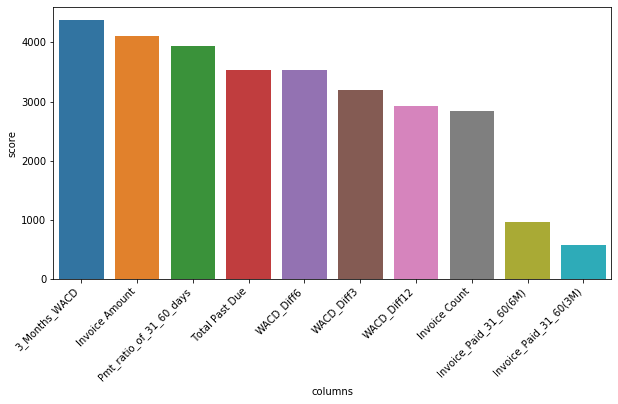

In [29]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(Feature_importances['columns'],Feature_importances['score'])
plt.xticks(rotation = 45,ha='right')

# Validation(Non_Balanced)

# validation_1(dec_data)

In [30]:
X_valid1=validation_1.drop(['label'],axis=1)
y_valid1=validation_1.label

y_val1=lgb_estimator.predict(X_valid1)
y_val1_prob=lgb_estimator.predict_proba(X_valid1)[:,1]

print(classification_report(y_valid1,y_val1))
print(confusion_matrix(y_valid1,y_val1))

              precision    recall  f1-score   support

           0       0.49      0.32      0.39      1131
           1       0.81      0.90      0.85      3607

    accuracy                           0.76      4738
   macro avg       0.65      0.61      0.62      4738
weighted avg       0.73      0.76      0.74      4738

[[ 366  765]
 [ 377 3230]]


# validation_2(500-500 sample from each class)

In [35]:
X_valid2=validation_2.drop(['label'],axis=1)
y_valid2=validation_2.label

y_val2=lgb_estimator.predict(X_valid2)
y_val2_prob=lgb_estimator.predict_proba(X_valid2)[:,1]

print(classification_report(y_valid2,y_val2))
print(confusion_matrix(y_valid2,y_val2))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       500
           1       0.67      0.85      0.75       500

    accuracy                           0.71      1000
   macro avg       0.73      0.71      0.71      1000
weighted avg       0.73      0.71      0.71      1000

[[291 209]
 [ 76 424]]


In [36]:
# def risk_catagory(data):
#     if data>=0.906619:
#         return 'High'
#     elif data<0.906619 and data>=0.707894:
#         return 'Medium'
#     elif data<0.707894 and data>0.5:
#         return 'Low'
#     else:
#         return 'Very_Low'

# Risk catagories dataframe

In [37]:
# X_test['Probability']=y_prob_cutoff
# X_valid1['Probability']=y_val1_prob
# X_valid2['Probability']=y_val2_prob

In [38]:
# X_test['Class']=X_test['Probability'].apply(lambda x:risk_catagory(x))
# X_valid1['Class']=X_valid1['Probability'].apply(lambda x:risk_catagory(x))
# X_valid2['Class']=X_valid2['Probability'].apply(lambda x:risk_catagory(x))

In [39]:
# High_Risk_Customer_test=X_test[X_test['Class']=='High'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Medium_Risk_Customer_test=X_test[X_test['Class']=='Medium'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Low_Risk_Customer_test=X_test[X_test['Class']=='Low'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Very_Low_Risk_Customer_test=X_test[X_test['Class']=='Vey_Low'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)

In [40]:
# High_Risk_Customer_val1=X_valid1[X_valid1['Class']=='High'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Medium_Risk_Customer_val1=X_valid1[X_valid1['Class']=='Medium'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Low_Risk_Customer_val1=X_valid1[X_valid1['Class']=='Low'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Very_Low_Risk_Customer_val1=X_valid1[X_valid1['Class']=='Vey_Low'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)

In [41]:
# High_Risk_Customer_val2=X_valid2[X_valid2['Class']=='High'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Medium_Risk_Customer_val2=X_valid2[X_valid2['Class']=='Medium'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Low_Risk_Customer_val2=X_valid2[X_valid2['Class']=='Low'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)
# Very_Low_Risk_Customer_val2=X_valid2[X_valid2['Class']=='Vey_Low'].sort_values('Total Past Due',ascending=False)[['Total Past Due','Probability','Class']].reset_index(drop=True)

# Roc_Curve(Non_Balanced)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.851


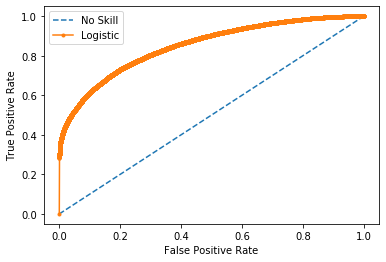

In [42]:
#Roc_Curve
#for logistic Regression
y_pred_logistic=lgb_estimator.predict_proba(X_test)

#for all model
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
y_pred_logistic=y_pred_logistic[:,1]

#for logistic Regression
ns_auc_logistic = roc_auc_score(y_test, ns_probs)
lr_auc_logistic = roc_auc_score(y_test, y_pred_logistic)

#for logistic Regression
print('No Skill: ROC AUC=%.3f' % (ns_auc_logistic))
print('Logistic: ROC AUC=%.3f' % (lr_auc_logistic))

# calculate roc curves for logistic Regression
ns_fpr_logistic, ns_tpr_logistic, _ = roc_curve(y_test, ns_probs)
lr_fpr_logistic, lr_tpr_logistic, _ = roc_curve(y_test, y_pred_logistic)

# plot the roc curve for the model
plt.plot(ns_fpr_logistic, ns_tpr_logistic, linestyle='--', label='No Skill')
plt.plot(lr_fpr_logistic, lr_tpr_logistic, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Ks_Table(Non_Balanced)

In [43]:
def ks_table(data_frame,pred_col_name = 'Probabilty',true_col_name = 'Target',responder_default = int(1),dec_no = 10):
    ascending_df = data_frame.sort_values(by = pred_col_name,ascending = False)
    length_df = len(data_frame)
    decile_len = length_df // dec_no
    total_resp = data_frame[true_col_name].value_counts().loc[1]
    total_non_resp = data_frame[true_col_name].value_counts().loc[0]
    temp_ks = pd.DataFrame({'RANK': [i + 1  for i in range(dec_no)],'TOTAL POP' : [decile_len]*dec_no,'MAX PROB':[np.nan] * dec_no,'MIN PROB':[np.nan] * dec_no,'NON-RESPONDERS':[np.nan]*dec_no,'RESPONDERS':[np.nan]*dec_no,'PERC RESPONDERS':[np.nan]*dec_no,'PERC NON-RESPONDERS':[np.nan]*dec_no,'CUM PERC RESPONDERS':[np.nan]*dec_no,'CUM PERC NON-RESPONDERS':[np.nan]*dec_no,'DIFFERENCE':[np.nan]*dec_no})
    cum_prec_responders = 0
    cum_prec_non_responders = 0
    for j in range(dec_no):
        if j < dec_no - 1:
            temp_df = ascending_df.iloc[decile_len*j:decile_len*(j+1)]
        else:
            temp_df = ascending_df.iloc[decile_len*j:]
        min_prob = min(temp_df[pred_col_name])
        max_prob = max(temp_df[pred_col_name])
        try:
            non_responders = temp_df[true_col_name].value_counts().loc[0]
        except KeyError:
            non_responders = 0
        try:
            responders = temp_df[true_col_name].value_counts().loc[1]
        except KeyError:
            responders = 0
        prec_responders = responders/total_resp
        prec_non_responders = non_responders/total_non_resp
        cum_prec_responders = prec_responders + cum_prec_responders
        cum_prec_non_responders = prec_non_responders + cum_prec_non_responders
        diff = cum_prec_responders - cum_prec_non_responders
        #temp_ks.loc[j,'EURVALUE'] = temp_df['EURVALUE'].sum()
        temp_ks.loc[j,'MAX PROB'] = format(max_prob, 'f')
        temp_ks.loc[j,'MIN PROB'] = format(min_prob, 'f')
        temp_ks.loc[j,'NON-RESPONDERS'] = int(non_responders) 
        temp_ks.loc[j,'RESPONDERS'] = int(responders)
        temp_ks.loc[j,'PERC RESPONDERS'] = prec_responders
        temp_ks.loc[j,'PERC NON-RESPONDERS'] = prec_non_responders
        temp_ks.loc[j,'CUM PERC RESPONDERS'] = cum_prec_responders
        temp_ks.loc[j,'CUM PERC NON-RESPONDERS'] = cum_prec_non_responders
        temp_ks.loc[j,'DIFFERENCE'] = format(diff, 'f')
    
    return temp_ks
        
predictions_test = pd.DataFrame({'Target': y_test,'Probabilty':y_prob_cutoff})
predictions_val1 = pd.DataFrame({'Target': y_valid1,'Probabilty':y_val1_prob})
predictions_val2 = pd.DataFrame({'Target': y_valid2,'Probabilty':y_val2_prob})    ##### preds is nothing but your y_val

# KS_Table(Test)

In [44]:
ks_table(predictions_test)

,RANK,TOTAL POP,MAX PROB,MIN PROB,NON-RESPONDERS,RESPONDERS,PERC RESPONDERS,PERC NON-RESPONDERS,CUM PERC RESPONDERS,CUM PERC NON-RESPONDERS,DIFFERENCE
0,1,6029,1.000000,1.000000,4.0,6025.0,0.147512,0.000206,0.147512,0.000206,0.147307
1,2,6029,1.000000,0.992487,5.0,6024.0,0.147488,0.000257,0.295000,0.000463,0.294538
2,3,6029,0.992477,0.872348,342.0,5687.0,0.139237,0.017584,0.434238,0.018046,0.416191
3,4,6029,0.872320,0.790607,975.0,5054.0,0.123739,0.050129,0.557977,0.068175,0.489802
4,5,6029,0.790583,0.708080,1487.0,4542.0,0.111204,0.076452,0.669180,0.144627,0.524553
5,6,6029,0.708055,0.618208,1998.0,4031.0,0.098693,0.102725,0.767873,0.247352,0.520521
6,7,6029,0.618207,0.524237,2606.0,3423.0,0.083807,0.133985,0.851680,0.381337,0.470343
7,8,6029,0.524227,0.424652,3210.0,2819.0,0.069019,0.165039,0.920698,0.546375,0.374323
8,9,6029,0.424648,0.309371,3847.0,2182.0,0.053423,0.197789,0.974121,0.744165,0.229957
9,10,6029,0.309339,0.000000,4976.0,1057.0,0.025879,0.255835,1.000000,1.000000,0.000000


# KS_Table(val_1 dec_data)

In [45]:
ks_table(predictions_val1)

,RANK,TOTAL POP,MAX PROB,MIN PROB,NON-RESPONDERS,RESPONDERS,PERC RESPONDERS,PERC NON-RESPONDERS,CUM PERC RESPONDERS,CUM PERC NON-RESPONDERS,DIFFERENCE
0,1,473,1.000000,1.000000,55.0,418.0,0.115886,0.048630,0.115886,0.048630,0.067256
1,2,473,1.000000,1.000000,69.0,404.0,0.112004,0.061008,0.227890,0.109637,0.118253
2,3,473,1.000000,0.987360,36.0,437.0,0.121153,0.031830,0.349044,0.141468,0.207576
3,4,473,0.987350,0.902516,66.0,407.0,0.112836,0.058355,0.461880,0.199823,0.262057
4,5,473,0.902495,0.833501,68.0,405.0,0.112282,0.060124,0.574161,0.259947,0.314214
5,6,473,0.833288,0.752659,118.0,355.0,0.098420,0.104332,0.672581,0.364279,0.308302
6,7,473,0.752594,0.658699,120.0,353.0,0.097865,0.106101,0.770446,0.470380,0.300066
7,8,473,0.658263,0.548944,170.0,303.0,0.084003,0.150309,0.854450,0.620690,0.233760
8,9,473,0.548840,0.431362,160.0,313.0,0.086776,0.141468,0.941225,0.762157,0.179068
9,10,473,0.430690,0.000000,269.0,212.0,0.058775,0.237843,1.000000,1.000000,0.000000


# KS_Table(val_2 500-500 sample data)

In [46]:
ks_table(predictions_val2)

,RANK,TOTAL POP,MAX PROB,MIN PROB,NON-RESPONDERS,RESPONDERS,PERC RESPONDERS,PERC NON-RESPONDERS,CUM PERC RESPONDERS,CUM PERC NON-RESPONDERS,DIFFERENCE
0,1,100,1.000000,1.000000,1.0,99.0,0.198,0.002,0.198,0.002,0.196000
1,2,100,1.000000,0.908746,4.0,96.0,0.192,0.008,0.390,0.010,0.380000
2,3,100,0.907178,0.807904,25.0,75.0,0.150,0.050,0.540,0.060,0.480000
3,4,100,0.805482,0.717443,39.0,61.0,0.122,0.078,0.662,0.138,0.524000
4,5,100,0.717254,0.611973,50.0,50.0,0.100,0.100,0.762,0.238,0.524000
5,6,100,0.611702,0.530950,64.0,36.0,0.072,0.128,0.834,0.366,0.468000
6,7,100,0.529857,0.442053,71.0,29.0,0.058,0.142,0.892,0.508,0.384000
7,8,100,0.441587,0.353847,75.0,25.0,0.050,0.150,0.942,0.658,0.284000
8,9,100,0.353523,0.254326,80.0,20.0,0.040,0.160,0.982,0.818,0.164000
9,10,100,0.251018,0.001118,91.0,9.0,0.018,0.182,1.000,1.000,0.000000


In [ ]:
#new
#High -- 0.906619
# medium -- 0.707894

In [ ]:
# high  >= 0.906619
# medium >= 0.707894  and < 0.906619
# low >.5 and < 0.707894